In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.inspection import permutation_importance

import scipy.stats as scipy

In [83]:
pd.__version__

'1.4.2'

In [10]:
dataset = pd.read_csv("Phishing_Legitimate_full.csv")
features = dataset.drop(['id', 'CLASS_LABEL'], axis=1)
pre_processed_features = features.to_numpy()
scaler = StandardScaler().fit(pre_processed_features)
X = scaler.transform(pre_processed_features)
y = pd.DataFrame(dataset["CLASS_LABEL"]).values.ravel()
#X_train, X_test, y_train, y_test = \
#                 train_test_split(X, y, stratify=y, random_state=42)
metrics = pd.DataFrame()

In [11]:
def display_results(data, period):
    # DISPLAY PATTERN
    acc_str = "ACCURACY: " + ' '*10 + "{:.5f}\n".format(np.array(data).mean())
    std_str = "STANDARD DEVIATION: {:.5f}\n".format(np.array(data).std())
    buffer_str = '='*20 + '\n'
    display_str = buffer_str + period + ": \n" + acc_str + std_str + buffer_str
    
    print(display_str)

In [20]:
def testbed(model, X, y, plot_title):
    true_positive_rates = []
    area_under_curves = []
    mean_fpr = np.linspace(0, 1, 100)
    
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results_training = [[],[],[],[],[]]
    results_testing = [[],[],[],[],[]]

    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)

    fig, ax = plt.subplots()

    # EPOCH
    for index, (train, test) in enumerate(kf.split(features)):
        model.fit(X[train], y[train])

        # PLOTTING EACH FOLD OF ROC CURVE
        roc_plot = RocCurveDisplay.from_estimator(
            model,
            X[test],
            y[test],
            name="Fold {}".format(index),
            ax=ax
        )

        # INTERPOLATE TRUE POSITIVE RATE
        interp_tpr = np.interp(mean_fpr, roc_plot.fpr, roc_plot.tpr)
        interp_tpr[0] = 0.0

        true_positive_rates.append(interp_tpr)
        area_under_curves.append(roc_plot.roc_auc)

        # PREDICT TRAINING
        y_pred = model.predict(X[train])
        accuracy = accuracy_score(y[train], y_pred)
        results_training[index].append(accuracy)

        # PREDICT TESTING
        y_pred = model.predict(X[test])
        accuracy = accuracy_score(y[test], y_pred)
        results_testing[index].append(accuracy)

    training_data = []
    testing_data  = []
    for index in range(5):
        training_data.append(np.array(results_training[index]).mean())
        testing_data.append(np.array(results_testing[index]).mean())
        
    # VISUAL RESPONSE AND GRAPHICS
    display_results(training_data, "TRAIN")
    display_results(testing_data, "TEST")

    mean_tpr = np.mean(true_positive_rates, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(area_under_curves)
    ax.plot(
        mean_fpr,
        mean_tpr,
        label="Mean ROC"
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=plot_title
    )
    ax.legend(loc="lower right")
    plt.show()

    results = cross_validate(estimator=model, X=X, y=y, cv=5,scoring=scoring,return_train_score=True)
  
    metrics = {"Model Name": plot_title, "Results": results, "Mean False Positive Rate": mean_fpr, "Mean True Positive Rate": mean_tpr, "Mean Area Under Curve": mean_auc, "Standard AUC Deviation": std_auc}
    return metrics

TRAIN: 
ACCURACY:           0.83805
STANDARD DEVIATION: 0.01050

TEST: 
ACCURACY:           0.83910
STANDARD DEVIATION: 0.01529



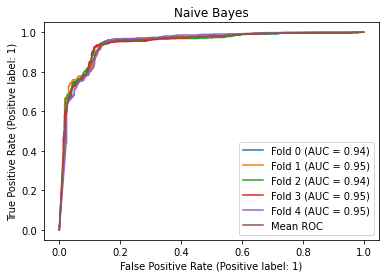

In [21]:
model = GaussianNB()
NB_metrics = testbed(model, X, y, 'Naive Bayes')

max_depth=6
TRAIN: 
ACCURACY:           0.97067
STANDARD DEVIATION: 0.00098

TEST: 
ACCURACY:           0.96550
STANDARD DEVIATION: 0.00342



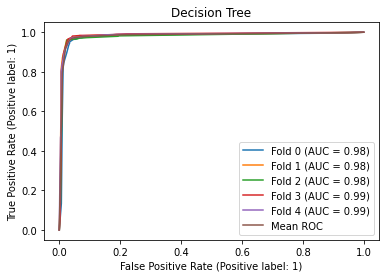

In [48]:
title = 'Decision Tree'
# For each testbed, the hiperparamenter is varied accordingly. The best overall result is selected to be saved

print("max_depth=6")
model = DecisionTreeClassifier(criterion='entropy', max_depth=6)
DT_metrics = testbed(model, X, y, title)

TRAIN: 
ACCURACY:           0.94938
STANDARD DEVIATION: 0.00112

TEST: 
ACCURACY:           0.94540
STANDARD DEVIATION: 0.00240



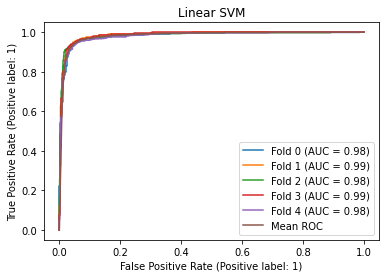

TRAIN: 
ACCURACY:           0.84542
STANDARD DEVIATION: 0.00310

TEST: 
ACCURACY:           0.84440
STANDARD DEVIATION: 0.00947



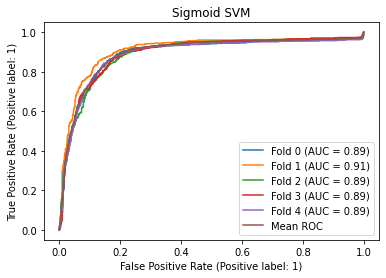

TRAIN: 
ACCURACY:           0.96370
STANDARD DEVIATION: 0.00051

TEST: 
ACCURACY:           0.95150
STANDARD DEVIATION: 0.00439



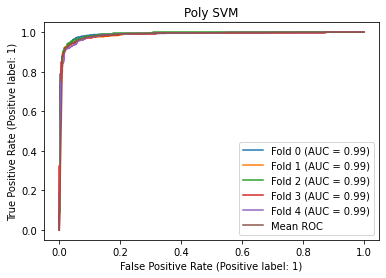

TRAIN: 
ACCURACY:           0.97267
STANDARD DEVIATION: 0.00050

TEST: 
ACCURACY:           0.96400
STANDARD DEVIATION: 0.00385



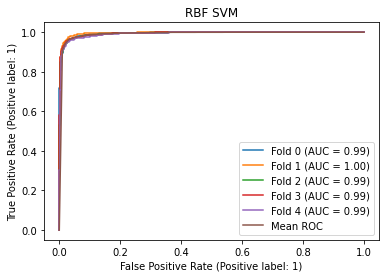

In [49]:
# For each testbed, the hiperparamenter is varied accordingly. All results are saved for comparison

model = SVC(kernel="linear", probability=True)
LSVM_metrics = testbed(model, X, y, "Linear SVM")

model = SVC(kernel="sigmoid", probability=True)
SSVM_metrics = testbed(model, X, y, "Sigmoid SVM")

model = SVC(kernel="poly", probability=True)
PSVM_metrics = testbed(model, X, y, "Poly SVM")

model = SVC(kernel="rbf", probability=True)
RSVM_metrics = testbed(model, X, y, "RBF SVM")

k-NN with n_neighbors=15
TRAIN: 
ACCURACY:           0.94380
STANDARD DEVIATION: 0.00146

TEST: 
ACCURACY:           0.93740
STANDARD DEVIATION: 0.00585



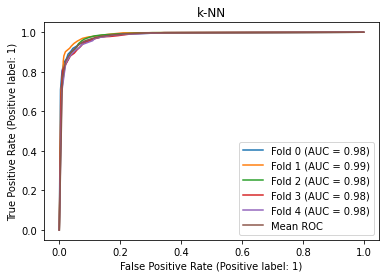

In [50]:
title = "k-NN"
# For each testbed, the hiperparamenter is varied accordingly. The best overall result is selected to be saved

print("k-NN with n_neighbors=15")
model = KNeighborsClassifier(n_neighbors=15)
knn_metrics = testbed(model, X, y, title)

Random Forrest with n_estimators=10
TRAIN: 
ACCURACY:           0.99910
STANDARD DEVIATION: 0.00029

TEST: 
ACCURACY:           0.97900
STANDARD DEVIATION: 0.00261



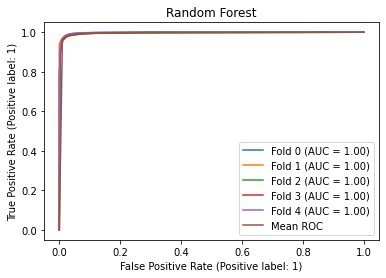

In [51]:
title = "Random Forest"
# For each testbed, the hiperparamenter is varied accordingly. The best overall result is selected to be saved

print("Random Forrest with n_estimators=10")
model = RandomForestClassifier(n_estimators=10)
RF_metrics = testbed(model, X, y, title)

GTB with n_estimators=80
TRAIN: 
ACCURACY:           0.98035
STANDARD DEVIATION: 0.00060

TEST: 
ACCURACY:           0.97430
STANDARD DEVIATION: 0.00220



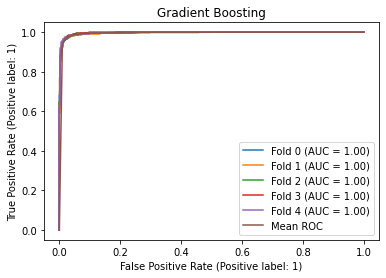

In [52]:
title = "Gradient Boosting"
# For each testbed, the hiperparamenter is varied accordingly. The best overall result is selected to be saved

print("GTB with n_estimators=80")
model = GradientBoostingClassifier(n_estimators=80)
GTB_metrics = testbed(model, X, y, title)

In [53]:
# Agregating all metrics together
import warnings
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.")
metrics_df = pd.DataFrame(columns=["Model Name", "Results", "Mean False Positive Rate", "Mean True Positive Rate", "Mean Area Under Curve", "Standard AUC Deviation"])
metrics_df = metrics_df.append(NB_metrics, ignore_index=True)
metrics_df = metrics_df.append(DT_metrics, ignore_index=True)
metrics_df = metrics_df.append(LSVM_metrics, ignore_index=True)
metrics_df = metrics_df.append(SSVM_metrics, ignore_index=True)
metrics_df = metrics_df.append(PSVM_metrics, ignore_index=True)
metrics_df = metrics_df.append(RSVM_metrics, ignore_index=True)
metrics_df = metrics_df.append(knn_metrics, ignore_index=True)
metrics_df = metrics_df.append(RF_metrics, ignore_index=True)
metrics_df = metrics_df.append(GTB_metrics, ignore_index=True)

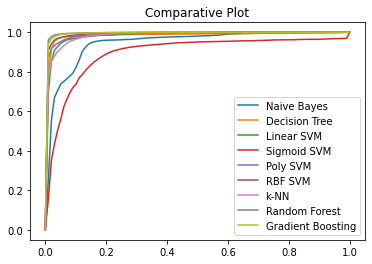

,Model Name,Mean Area Under Curve,Standard AUC Deviation,Train Precision and Deviation,Test Precision and Deviation
0,Naive Bayes,0.945028,0.001472,"(0.9457891027589842, 0.008554942286773405)","(0.9445766271056122, 0.00894596025964112)"
1,Decision Tree,0.982649,0.003221,"(0.9728285584478371, 0.003147085509690234)","(0.9629353949276853, 0.0072216041700079)"
2,Linear SVM,0.982121,0.002072,"(0.9449765391198811, 0.0034011422127930716)","(0.9257313750689841, 0.022752266867218637)"
3,Sigmoid SVM,0.893127,0.008048,"(0.8420475305506102, 0.008126437045522203)","(0.829403717694776, 0.011627426927755433)"
4,Poly SVM,0.986384,0.001343,"(0.971113669437484, 0.003017481389316752)","(0.9483321646834459, 0.025953014216473346)"
5,RBF SVM,0.990388,0.00117,"(0.9725616021515094, 0.0019631072873250986)","(0.9471769163473743, 0.022584231771630575)"
6,k-NN,0.982293,0.002313,"(0.94323794368944, 0.004276842646991959)","(0.9171810065925732, 0.036728459722723414)"
7,Random Forest,0.992868,0.001127,"(0.9995995243427626, 0.0001227608062389904)","(0.9793071300335487, 0.010658059332913772)"
8,Gradient Boosting,0.992689,0.000475,"(0.9799259021638946, 0.0015974356334422333)","(0.9680213095697514, 0.007027004737362441)"


In [54]:
fig, ax = plt.subplots()

trainpd = []
testpd = []
for index in range(9):
    mfpr = metrics_df["Mean False Positive Rate"][index]
    mtpr = metrics_df["Mean True Positive Rate"][index]
    ax.plot(
        mfpr,
        mtpr,
        label = metrics_df["Model Name"][index]
    )

    results =  metrics_df["Results"][index]
    train_precision_mean = results["train_precision"].mean() 
    test_precision_mean  = results["test_precision"].mean()
    train_precision_std = results["train_precision"].std() 
    test_precision_std  = results["test_precision"].std()

    trainpd.append((train_precision_mean, train_precision_std))
    testpd.append((test_precision_mean, test_precision_std))

metrics_df["Train Precision and Deviation"] = trainpd
metrics_df["Test Precision and Deviation"] = testpd

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Comparative Plot",
)
ax.legend(loc="lower right")
plt.show()
analyse_metrics = metrics_df.drop(metrics_df.columns[[1, 2, 3]], axis=1)
analyse_metrics

Elapsed time to compute the importances: 1.318 seconds


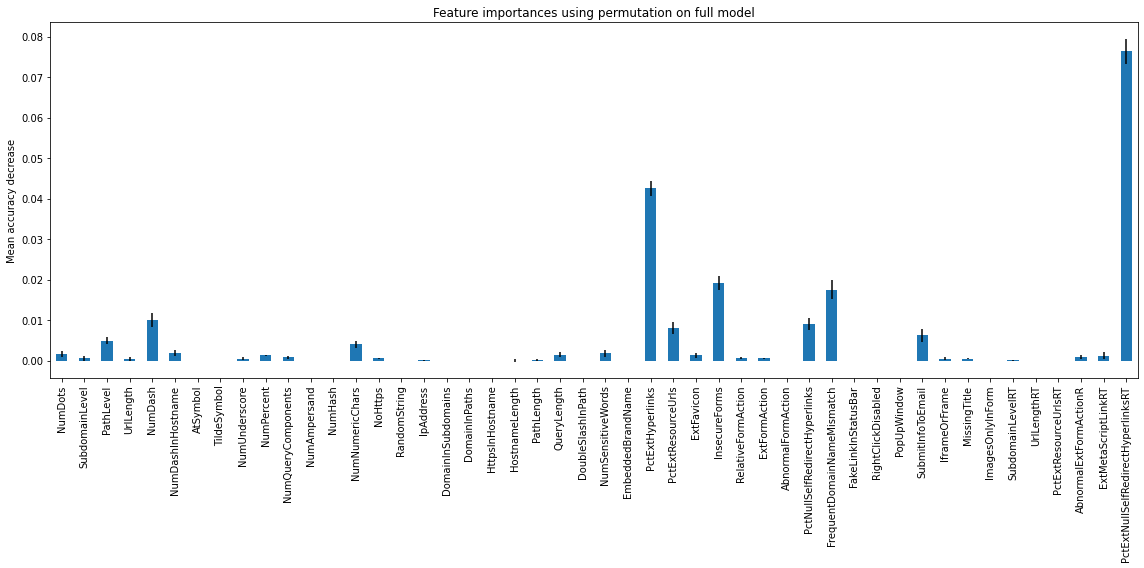

In [74]:
feature_names = list(features.columns)
X_train, X_test, y_train, y_test = train_test_split(features, y, stratify=y, random_state=42)
model = GradientBoostingClassifier(n_estimators=80)
model.fit(X_train, y_train)
start_time = time.time()
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

model_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(16,8))
model_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()